# Neural Network Project
By Le Yhuelic Noé / Kau William / Le Bourhis Vianney

This project aims to generate music using neural networks, specifically LSTM models, to predict note pitch and duration. MIDI files from the "Dataset" folder serve as the dataset. The process involves extracting musical information from MIDI files, creating a structured dataframe, and mapping pitches for model input. Three LSTM models are built and compared: one without embedding, one with embedding for notes concatenated with duration, and one predicting only notes using embedding with a fixed duration. Training incorporates a custom batch generation function and manual early stopping and checkpointing. The trained models generate music sequences from a seed, saved as MIDI files and converted to WAV for playback. Models with two outputs are evaluated based on their validation loss and further compared to a model with one output. The subjective quality of the generated music is assessed via audio playback. The project demonstrates the use of LSTM networks for musical sequence generation, highlighting the importance of data pre-processing and model architecture.




## Dataset used

The dataset used in this project comprises 28 MIDI files of Beethoven's songs, providing a diverse representation of his musical styles. Each file contains detailed information about note pitch, duration, tempos, instruments used, and total duration. Preprocessing steps involve extracting this musical information, organizing it into structured DataFrames, and mapping pitches to numerical indices for use in neural network models. While the dataset is relatively small, it's a suitable starting point for music generation tasks.

In [ ]:
# Import Tensorflow 2.0
#%tensorflow_version 2.x
import tensorflow as tf

# Import all remaining packages
import numpy as np
import os
import time
import functools
from IPython import display as ipythondisplay
from IPython.display import Audio
#from tqdm import tqdm
import json
import util
import pretty_midi
import pandas as pd

import warnings
# Ignorer tous les avertissements de Python
warnings.filterwarnings("ignore")

c:\Users\DELL\OneDrive - DVHE\Bureau\Projet


In [ ]:

midi_file_path = 'archive/appass_1.mid'
midi_info = util.extract_midi_info(midi_file_path)

# Affichage des informations extraites
print(f"Notes information: {midi_info['notes_info']}")
print(f"Tempos: {midi_info['tempos']}")
print(f"Instruments used: {midi_info['instruments_used']}")
print(f"Duration: {midi_info['duration']} seconds")

Notes information: [{'note': 'C4', 'start_time': np.float64(1.6281719999999997), 'end_time': np.float64(2.14681175), 'velocity': 35}, {'note': 'G#3', 'start_time': np.float64(2.14681175), 'end_time': np.float64(2.28341125), 'velocity': 31}, {'note': 'F3', 'start_time': np.float64(2.28341125), 'end_time': np.float64(3.9527582499999996), 'velocity': 28}, {'note': 'G#3', 'start_time': np.float64(3.9527582499999996), 'end_time': np.float64(4.43008875), 'velocity': 35}, {'note': 'C4', 'start_time': np.float64(4.43008875), 'end_time': np.float64(4.5375155000000005), 'velocity': 30}, {'note': 'F4', 'start_time': np.float64(4.5375155000000005), 'end_time': np.float64(5.0658080000000005), 'velocity': 35}, {'note': 'G#4', 'start_time': np.float64(5.0658080000000005), 'end_time': np.float64(5.53390075), 'velocity': 35}, {'note': 'C5', 'start_time': np.float64(5.53390075), 'end_time': np.float64(5.635451), 'velocity': 30}, {'note': 'F5', 'start_time': np.float64(5.635451), 'end_time': np.float64(6

In [ ]:

output_wav_path = 'output_audio.wav'           # Le fichier WAV de sortie

util.midi_to_wav(midi_file_path, output_wav_path)

In [ ]:
from IPython.display import Audio

# Charger et jouer le fichier audio
Audio("output_audio.wav")

ValueError: rate must be specified when data is a numpy array or list of audio samples.

Let's fetch all the midi files in our dataset

In [ ]:
from pathlib import Path
folder_path = Path("archive")
midi_infos = []
for file_path in folder_path.glob("*.mid"):
    midi_info = util.extract_midi_info(str(file_path))
    midi_infos.append(midi_info)

print(len(midi_infos))


28


# Midi Data Preprocessing

The goal of the preprocessing stage is to transform the raw MIDI data into a format suitable for training the LSTM models. The preprocessing pipeline consists of the following steps:

-MIDI Information Extraction:

The util.extract_midi_info function is used to extract essential information from each MIDI file in the dataset.
Extracted information includes notes information (pitch, start/end times), tempos, instruments used, and total duration.

-Creating Note DataFrames:

The fetch_notes function processes the extracted notes information.
It creates a pandas DataFrame containing 'Pitch Number', 'Note Name', and 'Duration' for each note in a MIDI file.

-Pitch Mapping:

Unique pitch values across all MIDI files are collected.
Dictionaries pitch_to_index and index_to_pitch are created to map pitch numbers to numerical indices and vice versa.
A new column 'Pitch Mapped' is added to the DataFrames, storing the mapped pitch indices.

-Batch Generation Function:

The get_batch function generates batches of data for model training.
It randomly selects MIDI files, extracts note sequences and durations, and converts them into tensors for the model.


This preprocessing stage prepares the musical data for training the LSTM models by organizing it into a structured format, mapping pitch values to numerical representations, and providing a mechanism for generating training batches. This ensures that the models can effectively learn patterns and generate new musical sequences.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
def fetch_notes(midi_info):
    # Créer des listes vides pour stocker les pitches et les noms de notesfe
    pitches = []
    note_names = []
    duration_note=[]

    # Parcours des informations des notes
    for note in midi_info['notes_info']:
        # Récupérer le nom de la note
        note_name = note['note']
        duration = note["end_time"]-note["start_time"]

        # Convertir le nom de la note en pitch (numéro de la note)
        pitch_number = pretty_midi.note_name_to_number(note_name)

        # Ajouter les valeurs aux listes
        pitches.append(pitch_number)
        note_names.append(note_name)
        duration_note.append(duration)# *100) On enlève le 100

    # Créer un DataFrame à partir des listes
    df_notes = pd.DataFrame({
        'Pitch Number': pitches,
        'Note Name': note_names,
        "Duration":duration_note
    })

    # Retourner le DataFrame
    return df_notes

dfs = []
for midi_info in midi_infos:
    df= fetch_notes(midi_info)
    dfs.append(df)

dfs[0].info()
dfs[0].head(100)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6377 entries, 0 to 6376
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Pitch Number  6377 non-null   int64  
 1   Note Name     6377 non-null   object 
 2   Duration      6377 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 149.6+ KB


,Pitch Number,Note Name,Duration
0,60,C4,0.518640
1,56,G#3,0.136599
2,53,F3,1.669347
3,56,G#3,0.477331
4,60,C4,0.107427
...,...,...,...
95,76,E5,0.105389
96,79,G5,0.105389
97,77,F5,0.115465
98,76,E5,0.346001


Let's create another dataframe that will map the unique value of our notes.

In [ ]:
# Récupérer toutes les valeurs de "Pitch Number"
all_notes = []
for df in dfs:
    if "Pitch Number" in df.columns:
        all_notes.extend(df["Pitch Number"].dropna().tolist())

# Obtenir les valeurs uniques
unique_notes = list(set(all_notes))
print(unique_notes)

[24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101]


In [ ]:
pitch_to_index = {pitch: i for i, pitch in enumerate(unique_notes)}
index_to_pitch = {i: pitch for pitch, i in pitch_to_index.items()}

In [ ]:
print(index_to_pitch)

{0: 24, 1: 25, 2: 26, 3: 27, 4: 28, 5: 29, 6: 30, 7: 31, 8: 32, 9: 33, 10: 34, 11: 35, 12: 36, 13: 37, 14: 38, 15: 39, 16: 40, 17: 41, 18: 42, 19: 43, 20: 44, 21: 45, 22: 46, 23: 47, 24: 48, 25: 49, 26: 50, 27: 51, 28: 52, 29: 53, 30: 54, 31: 55, 32: 56, 33: 57, 34: 58, 35: 59, 36: 60, 37: 61, 38: 62, 39: 63, 40: 64, 41: 65, 42: 66, 43: 67, 44: 68, 45: 69, 46: 70, 47: 71, 48: 72, 49: 73, 50: 74, 51: 75, 52: 76, 53: 77, 54: 78, 55: 79, 56: 80, 57: 81, 58: 82, 59: 83, 60: 84, 61: 85, 62: 86, 63: 87, 64: 88, 65: 89, 66: 90, 67: 91, 68: 92, 69: 93, 70: 94, 71: 95, 72: 96, 73: 97, 74: 98, 75: 99, 76: 100, 77: 101}


In [ ]:
for df in dfs:
    df["Pitch Mapped"] = df["Pitch Number"].map(pitch_to_index)
    df["Pitch DeMapped"] = df["Pitch Mapped"].map(index_to_pitch)

    print(df.head(100).to_string())

    Pitch Number Note Name  Duration  Pitch Mapped  Pitch DeMapped
0             60        C4  0.518640            36              60
1             56       G#3  0.136599            32              56
2             53        F3  1.669347            29              53
3             56       G#3  0.477331            32              56
4             60        C4  0.107427            36              60
5             65        F4  0.528293            41              65
6             68       G#4  0.468093            44              68
7             72        C5  0.101550            48              72
8             77        F5  0.558752            53              77
9             65        F4  0.556449            41              65
10            72        C5  0.927415            48              72
11            74        D5  0.149056            50              74
12            72        C5  0.049685            48              72
13            74        D5  0.057720            50            

In [ ]:
import numpy as np
import tensorflow as tf
import random

def get_batch(df_notes_list, seq_length, batch_size):

    input_batch = []
    output_batch = []

    while len(input_batch) < batch_size:
        # Choisir un df aléatoirement
        df = random.choice(df_notes_list)

        # Vérifier qu'il est assez long
        if df.shape[0] <= seq_length:
            continue  # Trop court, on passe

        vectorized = df[['Pitch Mapped', 'Duration']].values

        # Choisir un index de départ valide
        max_start = len(vectorized) - seq_length - 1
        i = np.random.randint(0, max_start + 1)

        # Créer une séquence et sa cible
        seq_input = vectorized[i:i+seq_length]
        seq_output = vectorized[i+seq_length]

        input_batch.append(seq_input)
        output_batch.append(seq_output)

    # Convertir en tensors
    x_batch = np.array(input_batch)
    y_batch = np.array(output_batch)

    x_batch_tensor = tf.convert_to_tensor(x_batch, dtype=tf.float32)
    y_batch_tensor = tf.convert_to_tensor(y_batch, dtype=tf.float32)

    return x_batch_tensor, y_batch_tensor


In [ ]:
x_batch, y_batch = get_batch(dfs, seq_length=10, batch_size=4)


In [ ]:
print(x_batch)

tf.Tensor(
[[[31.          0.16395268]
  [26.          0.16274562]
  [31.          0.16174372]
  [27.          0.16295373]
  [31.          0.16550927]
  [24.          0.1672985 ]
  [31.          0.1672985 ]
  [26.          0.1672985 ]
  [31.          0.1672985 ]
  [27.          0.1672985 ]]

 [[29.          0.1973685 ]
  [22.          0.372807  ]
  [29.          0.08720925]
  [29.          0.08720925]
  [29.          0.08720925]
  [29.          0.08720925]
  [29.          0.09090912]
  [29.          0.08522725]
  [29.          0.08620688]
  [27.          1.396779  ]]

 [[38.          0.16483513]
  [31.          3.3156025 ]
  [35.          0.21774201]
  [39.          0.22246942]
  [38.          0.17241375]
  [31.          0.6674082 ]
  [33.          0.22252741]
  [40.          0.21978016]
  [38.          0.16483513]
  [30.          0.6593405 ]]

 [[35.          3.428571  ]
  [29.          3.428571  ]
  [26.          3.428571  ]
  [12.          0.19373293]
  [24.          0.101561  ]
  [

In [ ]:
print(y_batch)

tf.Tensor(
[[31.          0.1672985 ]
 [21.          1.396779  ]
 [35.          0.21774201]
 [24.          0.09743425]], shape=(4, 2), dtype=float32)


In [ ]:
y_note = y_batch[:, 0]  # Pitch Number
y_duration = y_batch[:, 1]  # Duration
print(y_note)
print(y_duration)

tf.Tensor([31. 21. 35. 24.], shape=(4,), dtype=float32)
tf.Tensor([0.1672985  1.396779   0.21774201 0.09743425], shape=(4,), dtype=float32)


In [ ]:
print(len(x_batch))
print(len(y_batch))

4
4


## Let's use a LSTM model to compare our result

This section focuses on creating and training LSTM models for music generation.








In [ ]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Flatten, Concatenate

In [ ]:

batch_size = 32
seq_length = 100
learning_rate = 5e-3
epochs = 100

num_notes = len(unique_notes)
print(num_notes)


78


Our model wants to predict a note using classification and a duration using regression.
Normally for a LSTM, you need Embedding. But here with the duration, we can't use embedding. For this first case we will try LSTM without embedding.

In [ ]:
def create_model(seq_length,num_notes):
    inputs = Input(shape=(seq_length, 2))
    x = LSTM(units=100,input_shape=(seq_length,2), return_sequences=True, recurrent_activation='sigmoid')(inputs)
    x=LSTM(units=100, return_sequences=False, recurrent_activation='sigmoid')(x)

    #note_output = Dense(num_notes, activation='softmax', name="note_output")(x)  # Classification
    note_output = Dense(num_notes,name="note_output",activation="softmax")(x)  # Classification

    # Sortie Régression (Durée)
    duration_output = Dense(1,activation='relu', name="duration_output")(x)  # Régression

    # Modèle avec deux sorties
    lstm_model = Model(inputs=inputs, outputs=[note_output, duration_output])
    return lstm_model


In [ ]:
model = create_model(seq_length,num_notes)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100, 2)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 100, 100)  │     41,200 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 100)       │     80,400 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ note_output (Dense) │ (None, 78)        │      7,878 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ duration_output     │ (None, 1)         │        101 │ lstm_1[0][0]      │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 129,579 (506.17 KB)

 Trainable params: 129,579 (506.17 KB)

 Non-trainable params: 0 (0.00 B)

Unlike usual, we have 2 outputs, which results in 1 loss and metrics per output. One corresponds to classification (for the notes) and the other to regression (for the durations).

In [ ]:
def model_compile(model, learning_rate, loss_weights):
    model.compile(
        loss={
            "note_output": "sparse_categorical_crossentropy",  # Classification des notes
            "duration_output": "mean_squared_error"  # Régression des durées
        },
        loss_weights=loss_weights,  # Poids des pertes
        optimizer=tf.keras.optimizers.Adam(learning_rate),
        metrics={
            "note_output": ["accuracy"],  # Pour la classification
            "duration_output": ["mae"]  # Pour la régression
        }
    )


loss_weights = {
    "note_output": 1.0,
    "duration_output": 0.5
}
model_compile(model, learning_rate, loss_weights)


We implemented a custom Early Stopping mechanism because the standard model.fit function in TensorFlow wasn't suitable for our training process. This is due to our need for a custom training loop to handle the complexities of our specific dataset and model architecture.

To achieve this, we created custom classes for EarlyStopping and ModelCheckpoint, which give us control over the training process. This approach allows us to monitor the validation loss and stop the training when it plateaus, preventing overfitting and saving the best-performing model.

In [ ]:
class ManualEarlyStopping:
    def __init__(self, monitor='val_loss', patience=5, min_delta=0, mode='min', verbose=False):
        self.monitor = monitor
        self.patience = patience
        self.min_delta = min_delta
        self.mode = mode
        self.wait = 0
        self.verbose = verbose
        self.stop_training = False

        if self.mode == 'min':
            self.monitor_op = lambda current, best: current < best - self.min_delta
            self.best = float('inf')
        elif self.mode == 'max':
            self.monitor_op = lambda current, best: current > best + self.min_delta
            self.best = float('-inf')
        else:
            raise ValueError("mode must be either 'min' or 'max'")

    def __call__(self, current):
        if self.monitor_op(current, self.best):
            if self.verbose:
                print(f"{self.monitor} improved from {self.best:.4f} to {current:.4f}")
            self.best = current
            self.wait = 0
        else:
            self.wait += 1
            if self.verbose:
                print(f"{self.monitor} did not improve. Wait: {self.wait}/{self.patience}")
            if self.wait >= self.patience:
                if self.verbose:
                    print(f"Early stopping triggered: no improvement in {self.patience} epochs.")
                self.stop_training = True


In [ ]:
class ManualModelCheckpoint:
    def __init__(self, filepath, monitor='val_loss', save_best_only=True, mode='min', verbose=False):
        self.filepath = filepath
        self.monitor = monitor
        self.save_best_only = save_best_only
        self.verbose = verbose

        if mode == 'min':
            self.monitor_op = lambda current, best: current < best
            self.best = float('inf')
        elif mode == 'max':
            self.monitor_op = lambda current, best: current > best
            self.best = float('-inf')
        else:
            raise ValueError("mode must be either 'min' or 'max'")

    def __call__(self, model, current):
        if not self.save_best_only or self.monitor_op(current, self.best):
            if self.verbose:
                print(f"Saving model to {self.filepath} (best {self.monitor}: {current:.4f})")
            model.save(self.filepath)
            self.best = current


Function to apply Early stopping and modelcheckpoint

In [ ]:
def apply_callbacks(epoch, logs, model, early_stopping_cb, model_checkpoint_cb):
    """
    Applique EarlyStopping et ModelCheckpoint sur la métrique surveillée.

    Returns:
        bool: True si early stopping est déclenché, False sinon.
    """
    # Récupérer la métrique surveillée (ex: "val_loss")
    monitor_metric = early_stopping_cb.monitor

    if monitor_metric not in logs:
        raise ValueError(f"La métrique '{monitor_metric}' n'existe pas dans les logs : {list(logs.keys())}")

    current_value = logs[monitor_metric]

    # Appliquer ModelCheckpoint et EarlyStopping
    model_checkpoint_cb(model, current_value)
    early_stopping_cb(current_value)

    return early_stopping_cb.stop_training


In [ ]:
# Initialiser les callbacks
early_stopping = ManualEarlyStopping(monitor='val_loss', patience=15, mode='min',verbose=True)
checkpoint = ManualModelCheckpoint(filepath='model/best_model_manual.h5', monitor='val_loss', mode='min')

In [ ]:

def train_test(dfs,seq_length,batch_size,epochs,model):
    history = []
    # Boucle de génération des données
    for epoch in range(epochs):
        x_batch, y_batch = get_batch(dfs, seq_length, batch_size)

        # Séparer `y_batch` en deux sorties
        y_note = y_batch[:, 0]  # Pitch Number
        y_duration = y_batch[:, 1]  # Duration

        # Entraîner sur le batch
        losses = model.train_on_batch(x_batch, {"note_output": y_note, "duration_output": y_duration})

        # S'assurer que les pertes sont bien retournées sous forme de dictionnaire
        if isinstance(losses, list):  # Cas où Keras retourne une liste
            total_loss, note_loss, duration_loss = losses[:3]
        elif isinstance(losses, dict):  # Cas où Keras retourne un dict
            total_loss = losses["loss"]
            note_loss = losses["note_output_loss"]
            duration_loss = losses["duration_output_loss"]

        # Affichage formaté
        print(f"Epoch {epoch+1}/{epochs} - "
            f"Total Loss: {total_loss:.4f} - "
            f"Note Loss: {note_loss:.4f} - "
            f"Duration Loss: {duration_loss:.4f}")

        logs = {
            'val_note_output_accuracy': note_loss,
            'val_duration_output_mae': duration_loss,
            'val_loss': total_loss
        }
        history.append({
            'total_loss': total_loss,
            'note_loss': note_loss
        })
        # Vérifier si l'entraînement doit être arrêté
        if apply_callbacks(epoch, logs, model, early_stopping, checkpoint):
            break
    return history



In [ ]:
history1=train_test(dfs,seq_length,batch_size,epochs,model)

Epoch 1/100 - Total Loss: 4.6816 - Note Loss: 4.3457 - Duration Loss: 0.6718
val_loss improved from inf to 4.6816
Epoch 2/100 - Total Loss: 4.5562 - Note Loss: 4.2903 - Duration Loss: 0.5318
val_loss improved from 4.6816 to 4.5562


Epoch 3/100 - Total Loss: 4.5058 - Note Loss: 4.2411 - Duration Loss: 0.5294
val_loss improved from 4.5562 to 4.5058
Epoch 4/100 - Total Loss: 4.4473 - Note Loss: 4.2031 - Duration Loss: 0.4882
val_loss improved from 4.5058 to 4.4473


Epoch 5/100 - Total Loss: 4.4445 - Note Loss: 4.2149 - Duration Loss: 0.4592
val_loss improved from 4.4473 to 4.4445
Epoch 6/100 - Total Loss: 4.4216 - Note Loss: 4.2137 - Duration Loss: 0.4157
val_loss improved from 4.4445 to 4.4216


Epoch 7/100 - Total Loss: 4.3863 - Note Loss: 4.1925 - Duration Loss: 0.3877
val_loss improved from 4.4216 to 4.3863
Epoch 8/100 - Total Loss: 4.3963 - Note Loss: 4.1987 - Duration Loss: 0.3952
val_loss did not improve. Wait: 1/15
Epoch 9/100 - Total Loss: 4.3899 - Note Loss: 4.1508 - Duration Loss: 0.4783
val_loss did not improve. Wait: 2/15
Epoch 10/100 - Total Loss: 4.3990 - Note Loss: 4.1613 - Duration Loss: 0.4754
val_loss did not improve. Wait: 3/15


Epoch 11/100 - Total Loss: 4.3922 - Note Loss: 4.1708 - Duration Loss: 0.4429
val_loss did not improve. Wait: 4/15
Epoch 12/100 - Total Loss: 4.3687 - Note Loss: 4.1585 - Duration Loss: 0.4205


val_loss improved from 4.3863 to 4.3687
Epoch 13/100 - Total Loss: 4.3484 - Note Loss: 4.1497 - Duration Loss: 0.3975
val_loss improved from 4.3687 to 4.3484


Epoch 14/100 - Total Loss: 4.3401 - Note Loss: 4.1474 - Duration Loss: 0.3854
val_loss improved from 4.3484 to 4.3401
Epoch 15/100 - Total Loss: 4.3309 - Note Loss: 4.1460 - Duration Loss: 0.3697
val_loss improved from 4.3401 to 4.3309


Epoch 16/100 - Total Loss: 4.3352 - Note Loss: 4.1285 - Duration Loss: 0.4134
val_loss did not improve. Wait: 1/15
Epoch 17/100 - Total Loss: 4.3225 - Note Loss: 4.1169 - Duration Loss: 0.4112
val_loss improved from 4.3309 to 4.3225


Epoch 18/100 - Total Loss: 4.3005 - Note Loss: 4.0983 - Duration Loss: 0.4044
val_loss improved from 4.3225 to 4.3005
Epoch 19/100 - Total Loss: 4.2831 - Note Loss: 4.0868 - Duration Loss: 0.3924
val_loss improved from 4.3005 to 4.2831


Epoch 20/100 - Total Loss: 4.2832 - Note Loss: 4.0739 - Duration Loss: 0.4186
val_loss did not improve. Wait: 1/15
Epoch 21/100 - Total Loss: 4.2666 - Note Loss: 4.0620 - Duration Loss: 0.4092
val_loss improved from 4.2831 to 4.2666


Epoch 22/100 - Total Loss: 4.2549 - Note Loss: 4.0513 - Duration Loss: 0.4072
val_loss improved from 4.2666 to 4.2549
Epoch 23/100 - Total Loss: 4.2394 - Note Loss: 4.0404 - Duration Loss: 0.3979
val_loss improved from 4.2549 to 4.2394


Epoch 24/100 - Total Loss: 4.2206 - Note Loss: 4.0243 - Duration Loss: 0.3925
val_loss improved from 4.2394 to 4.2206
Epoch 25/100 - Total Loss: 4.2049 - Note Loss: 4.0102 - Duration Loss: 0.3893
val_loss improved from 4.2206 to 4.2049


Epoch 26/100 - Total Loss: 4.2004 - Note Loss: 4.0040 - Duration Loss: 0.3928
val_loss improved from 4.2049 to 4.2004
Epoch 27/100 - Total Loss: 4.1864 - Note Loss: 3.9913 - Duration Loss: 0.3901
val_loss improved from 4.2004 to 4.1864


Epoch 28/100 - Total Loss: 4.1814 - Note Loss: 3.9807 - Duration Loss: 0.4013
val_loss improved from 4.1864 to 4.1814
Epoch 29/100 - Total Loss: 4.1794 - Note Loss: 3.9665 - Duration Loss: 0.4258
val_loss improved from 4.1814 to 4.1794
Epoch 30/100 - Total Loss: 4.2125 - Note Loss: 3.9567 - Duration Loss: 0.5116
val_loss did not improve. Wait: 1/15
Epoch 31/100 - Total Loss: 4.2175 - Note Loss: 3.9472 - Duration Loss: 0.5405
val_loss did not improve. Wait: 2/15
Epoch 32/100 - Total Loss: 4.2115 - Note Loss: 3.9443 - Duration Loss: 0.5344
val_loss did not improve. Wait: 3/15
Epoch 33/100 - Total Loss: 4.2034 - Note Loss: 3.9374 - Duration Loss: 0.5320
val_loss did not improve. Wait: 4/15
Epoch 34/100 - Total Loss: 4.1893 - Note Loss: 3.9293 - Duration Loss: 0.5201
val_loss did not improve. Wait: 5/15
Epoch 35/100 - Total Loss: 4.1994 - Note Loss: 3.9304 - Duration Loss: 0.5380
val_loss did not improve. Wait: 6/15
Epoch 36/100 - Total Loss: 4.1801 - Note Loss: 3.9169 - Duration Loss: 0.5

val_loss improved from 4.1794 to 4.1757
Epoch 38/100 - Total Loss: 4.1793 - Note Loss: 3.9235 - Duration Loss: 0.5116
val_loss did not improve. Wait: 1/15
Epoch 39/100 - Total Loss: 4.1656 - Note Loss: 3.9141 - Duration Loss: 0.5031


val_loss improved from 4.1757 to 4.1656
Epoch 40/100 - Total Loss: 4.1613 - Note Loss: 3.9023 - Duration Loss: 0.5179
val_loss improved from 4.1656 to 4.1613


Epoch 41/100 - Total Loss: 4.1478 - Note Loss: 3.8907 - Duration Loss: 0.5142
val_loss improved from 4.1613 to 4.1478
Epoch 42/100 - Total Loss: 4.1293 - Note Loss: 3.8771 - Duration Loss: 0.5045
val_loss improved from 4.1478 to 4.1293


Epoch 43/100 - Total Loss: 4.1235 - Note Loss: 3.8668 - Duration Loss: 0.5134
val_loss improved from 4.1293 to 4.1235
Epoch 44/100 - Total Loss: 4.1140 - Note Loss: 3.8602 - Duration Loss: 0.5075
val_loss improved from 4.1235 to 4.1140


Epoch 45/100 - Total Loss: 4.1037 - Note Loss: 3.8495 - Duration Loss: 0.5084
val_loss improved from 4.1140 to 4.1037
Epoch 46/100 - Total Loss: 4.1043 - Note Loss: 3.8486 - Duration Loss: 0.5114
val_loss did not improve. Wait: 1/15


Epoch 47/100 - Total Loss: 4.0950 - Note Loss: 3.8398 - Duration Loss: 0.5103
val_loss improved from 4.1037 to 4.0950


Epoch 48/100 - Total Loss: 4.0896 - Note Loss: 3.8357 - Duration Loss: 0.5079
val_loss improved from 4.0950 to 4.0896
Epoch 49/100 - Total Loss: 4.0841 - Note Loss: 3.8327 - Duration Loss: 0.5028


val_loss improved from 4.0896 to 4.0841
Epoch 50/100 - Total Loss: 4.0785 - Note Loss: 3.8255 - Duration Loss: 0.5060
val_loss improved from 4.0841 to 4.0785


Epoch 51/100 - Total Loss: 4.0700 - Note Loss: 3.8168 - Duration Loss: 0.5064
val_loss improved from 4.0785 to 4.0700
Epoch 52/100 - Total Loss: 4.0622 - Note Loss: 3.8089 - Duration Loss: 0.5065
val_loss improved from 4.0700 to 4.0622
Epoch 53/100 - Total Loss: 4.0625 - Note Loss: 3.8014 - Duration Loss: 0.5221
val_loss did not improve. Wait: 1/15
Epoch 54/100 - Total Loss: 4.0529 - Note Loss: 3.7956 - Duration Loss: 0.5147


val_loss improved from 4.0622 to 4.0529
Epoch 55/100 - Total Loss: 4.0446 - Note Loss: 3.7885 - Duration Loss: 0.5123
val_loss improved from 4.0529 to 4.0446


Epoch 56/100 - Total Loss: 4.0446 - Note Loss: 3.7867 - Duration Loss: 0.5159
val_loss improved from 4.0446 to 4.0446
Epoch 57/100 - Total Loss: 4.0381 - Note Loss: 3.7840 - Duration Loss: 0.5082
val_loss improved from 4.0446 to 4.0381


Epoch 58/100 - Total Loss: 4.0425 - Note Loss: 3.7781 - Duration Loss: 0.5289
val_loss did not improve. Wait: 1/15
Epoch 59/100 - Total Loss: 4.0363 - Note Loss: 3.7681 - Duration Loss: 0.5363
val_loss improved from 4.0381 to 4.0363


Epoch 60/100 - Total Loss: 4.0358 - Note Loss: 3.7631 - Duration Loss: 0.5455
val_loss improved from 4.0363 to 4.0358
Epoch 61/100 - Total Loss: 4.0265 - Note Loss: 3.7560 - Duration Loss: 0.5410
val_loss improved from 4.0358 to 4.0265


Epoch 62/100 - Total Loss: 4.0207 - Note Loss: 3.7525 - Duration Loss: 0.5364
val_loss improved from 4.0265 to 4.0207
Epoch 63/100 - Total Loss: 4.0122 - Note Loss: 3.7449 - Duration Loss: 0.5345
val_loss improved from 4.0207 to 4.0122
Epoch 64/100 - Total Loss: 4.0207 - Note Loss: 3.7421 - Duration Loss: 0.5572
val_loss did not improve. Wait: 1/15
Epoch 65/100 - Total Loss: 4.0165 - Note Loss: 3.7341 - Duration Loss: 0.5649
val_loss did not improve. Wait: 2/15
Epoch 66/100 - Total Loss: 4.0090 - Note Loss: 3.7291 - Duration Loss: 0.5599


val_loss improved from 4.0122 to 4.0090
Epoch 67/100 - Total Loss: 4.0070 - Note Loss: 3.7254 - Duration Loss: 0.5633
val_loss improved from 4.0090 to 4.0070


Epoch 68/100 - Total Loss: 4.0034 - Note Loss: 3.7219 - Duration Loss: 0.5630
val_loss improved from 4.0070 to 4.0034
Epoch 69/100 - Total Loss: 3.9955 - Note Loss: 3.7157 - Duration Loss: 0.5597
val_loss improved from 4.0034 to 3.9955


Epoch 70/100 - Total Loss: 3.9978 - Note Loss: 3.7124 - Duration Loss: 0.5710
val_loss did not improve. Wait: 1/15
Epoch 71/100 - Total Loss: 3.9917 - Note Loss: 3.7047 - Duration Loss: 0.5739
val_loss improved from 3.9955 to 3.9917


Epoch 72/100 - Total Loss: 3.9845 - Note Loss: 3.6995 - Duration Loss: 0.5699
val_loss improved from 3.9917 to 3.9845
Epoch 73/100 - Total Loss: 3.9768 - Note Loss: 3.6949 - Duration Loss: 0.5638
val_loss improved from 3.9845 to 3.9768


Epoch 74/100 - Total Loss: 3.9697 - Note Loss: 3.6899 - Duration Loss: 0.5596
val_loss improved from 3.9768 to 3.9697
Epoch 75/100 - Total Loss: 3.9662 - Note Loss: 3.6857 - Duration Loss: 0.5610
val_loss improved from 3.9697 to 3.9662
Epoch 76/100 - Total Loss: 3.9713 - Note Loss: 3.6820 - Duration Loss: 0.5786
val_loss did not improve. Wait: 1/15
Epoch 77/100 - Total Loss: 3.9684 - Note Loss: 3.6814 - Duration Loss: 0.5739
val_loss did not improve. Wait: 2/15
Epoch 78/100 - Total Loss: 3.9595 - Note Loss: 3.6752 - Duration Loss: 0.5686


val_loss improved from 3.9662 to 3.9595
Epoch 79/100 - Total Loss: 3.9511 - Note Loss: 3.6699 - Duration Loss: 0.5623
val_loss improved from 3.9595 to 3.9511


Epoch 80/100 - Total Loss: 3.9490 - Note Loss: 3.6689 - Duration Loss: 0.5602
val_loss improved from 3.9511 to 3.9490
Epoch 81/100 - Total Loss: 3.9454 - Note Loss: 3.6647 - Duration Loss: 0.5613
val_loss improved from 3.9490 to 3.9454


Epoch 82/100 - Total Loss: 3.9453 - Note Loss: 3.6618 - Duration Loss: 0.5670
val_loss improved from 3.9454 to 3.9453
Epoch 83/100 - Total Loss: 3.9409 - Note Loss: 3.6599 - Duration Loss: 0.5619
val_loss improved from 3.9453 to 3.9409


Epoch 84/100 - Total Loss: 3.9398 - Note Loss: 3.6599 - Duration Loss: 0.5599
val_loss improved from 3.9409 to 3.9398
Epoch 85/100 - Total Loss: 3.9350 - Note Loss: 3.6572 - Duration Loss: 0.5556


val_loss improved from 3.9398 to 3.9350
Epoch 86/100 - Total Loss: 3.9330 - Note Loss: 3.6544 - Duration Loss: 0.5572
val_loss improved from 3.9350 to 3.9330


Epoch 87/100 - Total Loss: 3.9266 - Note Loss: 3.6503 - Duration Loss: 0.5527
val_loss improved from 3.9330 to 3.9266
Epoch 88/100 - Total Loss: 3.9226 - Note Loss: 3.6468 - Duration Loss: 0.5516
val_loss improved from 3.9266 to 3.9226
Epoch 89/100 - Total Loss: 3.9286 - Note Loss: 3.6470 - Duration Loss: 0.5632
val_loss did not improve. Wait: 1/15
Epoch 90/100 - Total Loss: 3.9299 - Note Loss: 3.6445 - Duration Loss: 0.5710
val_loss did not improve. Wait: 2/15
Epoch 91/100 - Total Loss: 3.9274 - Note Loss: 3.6420 - Duration Loss: 0.5708
val_loss did not improve. Wait: 3/15


Epoch 92/100 - Total Loss: 3.9244 - Note Loss: 3.6406 - Duration Loss: 0.5676
val_loss did not improve. Wait: 4/15
Epoch 93/100 - Total Loss: 3.9190 - Note Loss: 3.6373 - Duration Loss: 0.5633
val_loss improved from 3.9226 to 3.9190


Epoch 94/100 - Total Loss: 3.9149 - Note Loss: 3.6346 - Duration Loss: 0.5607
val_loss improved from 3.9190 to 3.9149
Epoch 95/100 - Total Loss: 3.9105 - Note Loss: 3.6314 - Duration Loss: 0.5583
val_loss improved from 3.9149 to 3.9105


Epoch 96/100 - Total Loss: 3.9080 - Note Loss: 3.6295 - Duration Loss: 0.5570
val_loss improved from 3.9105 to 3.9080


Epoch 97/100 - Total Loss: 3.9051 - Note Loss: 3.6265 - Duration Loss: 0.5572
val_loss improved from 3.9080 to 3.9051
Epoch 98/100 - Total Loss: 3.9027 - Note Loss: 3.6225 - Duration Loss: 0.5603


val_loss improved from 3.9051 to 3.9027
Epoch 99/100 - Total Loss: 3.8990 - Note Loss: 3.6187 - Duration Loss: 0.5607
val_loss improved from 3.9027 to 3.8990


Epoch 100/100 - Total Loss: 3.8983 - Note Loss: 3.6158 - Duration Loss: 0.5650
val_loss improved from 3.8990 to 3.8983


## We couldn't use Embedding in our case because our input shape is : (seq_length,2)
Let's try to use it using 1 embedding for the note that we will concatenate after with the duration.


In [ ]:
# Paramètres du Embedding
embedding_dim = 50  # Dimension des vecteurs d'embedding

In [ ]:
# Initialiser les callbacks
early_stopping_embedding = ManualEarlyStopping(monitor='val_loss', patience=10, mode='min',verbose=True)
checkpoint_embedding = ManualModelCheckpoint(filepath='model/best_model_embedding.h5', monitor='val_loss', mode='min')

Key Difference: We split the input into two parts: notes and durations. This allows us to apply embedding to the notes. Subsequently, we concatenate the embedded note layer with the duration layer as input to the LSTM.

Challenge: This approach leads to a size disparity: the embedding layer has a dimension of 50, while the duration layer has a dimension of 1. This imbalance might limit the model's ability to learn effectively from the duration information, as it has relatively fewer features.

Another Distinction: Similar to the previous model, this model has two outputs (note classification and duration regression), but it also features two distinct inputs (notes and durations)

In [ ]:
def create_model(seq_length, vocab_size, embedding_dim,num_notes):
    # Entrée pour les notes (indices)
    note_input = Input(shape=(seq_length,), name="note_input")

    # Entrée pour les durées (valeurs continues)
    duration_input = Input(shape=(seq_length, 1), name="duration_input")

    # Ajouter une couche d'embedding pour les notes
    note_embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=seq_length)(note_input)

    # Concaténer les embeddings des notes et les durées
    combined = Concatenate()([note_embedding, duration_input])

    # Ajouter une couche LSTM
    x = LSTM(units=100, return_sequences=True, recurrent_activation='sigmoid')(combined)
    x = LSTM(units=100, return_sequences=False, recurrent_activation='sigmoid')(x)

    # Sortie de classification (notes)
    note_output = Dense(num_notes, activation='softmax', name="note_output")(x)

    # Sortie de régression (durée)
    duration_output = Dense(1, activation='relu', name="duration_output")(x)

    # Modèle avec deux sorties
    lstm_model = Model(inputs=[note_input, duration_input], outputs=[note_output, duration_output])
    return lstm_model

# Le nombre de note et nombre de vocabulaire sont égaux
model_embedding = create_model(seq_length, num_notes, embedding_dim, num_notes)


In [ ]:
model_embedding.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ note_input          │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 100, 50)   │      3,900 │ note_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ duration_input      │ (None, 100, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 100, 51)   │          0 │ embedding[0][0],  │
│ (Concatenate)       │                   │            │ duration_input[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 100, 100)  │     60,800 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 100)       │     80,400 │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ note_output (Dense) │ (None, 78)        │      7,878 │ lstm_3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ duration_output     │ (None, 1)         │        101 │ lstm_3[0][0]      │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 153,079 (597.96 KB)

 Trainable params: 153,079 (597.96 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_compile(model_embedding,learning_rate,loss_weights)

In [ ]:
def train_test_embedding(dfs,seq_length,batch_size,epochs,model):
    history=[]
    # Boucle de génération des données
    for epoch in range(epochs):
        x_batch, y_batch = get_batch(dfs, seq_length, batch_size)

        # Séparer `x_batch` en deux entrées
        x_note = x_batch[:, :, 0]  # Indices des notes
        x_duration = x_batch[:, :, 1] # Durées

        # Séparer `y_batch` en deux sorties
        y_note = y_batch[:, 0]  # Pitch Number
        y_duration = y_batch[:, 1]  # Duration

        # Entraîner sur le batch
        losses = model.train_on_batch([x_note, x_duration], {"note_output": y_note, "duration_output": y_duration})


        # S'assurer que les pertes sont bien retournées sous forme de dictionnaire
        if isinstance(losses, list):  # Cas où Keras retourne une liste
            total_loss, note_loss, duration_loss = losses[:3]
        elif isinstance(losses, dict):  # Cas où Keras retourne un dict
            total_loss = losses["loss"]
            note_loss = losses["note_output_loss"]
            duration_loss = losses["duration_output_loss"]

        # Affichage formaté
        print(f"Epoch {epoch+1}/{epochs} - "
            f"Total Loss: {total_loss:.4f} - "
            f"Note Loss: {note_loss:.4f} - "
            f"Duration Loss: {duration_loss:.4f}")

        logs = {
            'val_note_output_accuracy': note_loss,
            'val_duration_output_mae': duration_loss,
            'val_loss': total_loss
        }
        history.append({
            'total_loss': total_loss,
            'note_loss': note_loss
        })
        # Vérifier si l'entraînement doit être arrêté
        if apply_callbacks(epoch, logs, model, early_stopping_embedding, checkpoint_embedding):
            break
    return history


In [ ]:
history2=train_test_embedding(dfs,seq_length,batch_size,epochs,model_embedding)

Epoch 1/100 - Total Loss: 4.7281 - Note Loss: 4.3596 - Duration Loss: 0.7370
val_loss improved from inf to 4.7281


Epoch 2/100 - Total Loss: 4.5521 - Note Loss: 4.3544 - Duration Loss: 0.3955
val_loss improved from 4.7281 to 4.5521


Epoch 3/100 - Total Loss: 4.5377 - Note Loss: 4.3516 - Duration Loss: 0.3721
val_loss improved from 4.5521 to 4.5377


Epoch 4/100 - Total Loss: 4.5027 - Note Loss: 4.3456 - Duration Loss: 0.3143
val_loss improved from 4.5377 to 4.5027


Epoch 5/100 - Total Loss: 4.4951 - Note Loss: 4.3434 - Duration Loss: 0.3034
val_loss improved from 4.5027 to 4.4951


Epoch 6/100 - Total Loss: 4.4745 - Note Loss: 4.3404 - Duration Loss: 0.2683
val_loss improved from 4.4951 to 4.4745


Epoch 7/100 - Total Loss: 4.4596 - Note Loss: 4.3335 - Duration Loss: 0.2522
val_loss improved from 4.4745 to 4.4596


Epoch 8/100 - Total Loss: 4.4404 - Note Loss: 4.3267 - Duration Loss: 0.2275
val_loss improved from 4.4596 to 4.4404


Epoch 9/100 - Total Loss: 4.4284 - Note Loss: 4.3156 - Duration Loss: 0.2255
val_loss improved from 4.4404 to 4.4284
Epoch 10/100 - Total Loss: 4.4466 - Note Loss: 4.2974 - Duration Loss: 0.2983
val_loss did not improve. Wait: 1/10
Epoch 11/100 - Total Loss: 4.4360 - Note Loss: 4.2809 - Duration Loss: 0.3101
val_loss did not improve. Wait: 2/10


Epoch 12/100 - Total Loss: 4.4103 - Note Loss: 4.2645 - Duration Loss: 0.2917
val_loss improved from 4.4284 to 4.4103
Epoch 13/100 - Total Loss: 4.4123 - Note Loss: 4.2572 - Duration Loss: 0.3102
val_loss did not improve. Wait: 1/10


Epoch 14/100 - Total Loss: 4.3921 - Note Loss: 4.2461 - Duration Loss: 0.2920
val_loss improved from 4.4103 to 4.3921


Epoch 15/100 - Total Loss: 4.3732 - Note Loss: 4.2322 - Duration Loss: 0.2821
val_loss improved from 4.3921 to 4.3732
Epoch 16/100 - Total Loss: 4.3675 - Note Loss: 4.2278 - Duration Loss: 0.2795


val_loss improved from 4.3732 to 4.3675
Epoch 17/100 - Total Loss: 4.3649 - Note Loss: 4.2194 - Duration Loss: 0.2911
val_loss improved from 4.3675 to 4.3649


Epoch 18/100 - Total Loss: 4.3600 - Note Loss: 4.2100 - Duration Loss: 0.2999
val_loss improved from 4.3649 to 4.3600
Epoch 19/100 - Total Loss: 4.3547 - Note Loss: 4.2057 - Duration Loss: 0.2980
val_loss improved from 4.3600 to 4.3547


Epoch 20/100 - Total Loss: 4.3358 - Note Loss: 4.1907 - Duration Loss: 0.2903
val_loss improved from 4.3547 to 4.3358
Epoch 21/100 - Total Loss: 4.3179 - Note Loss: 4.1769 - Duration Loss: 0.2821


val_loss improved from 4.3358 to 4.3179
Epoch 22/100 - Total Loss: 4.2922 - Note Loss: 4.1559 - Duration Loss: 0.2726
val_loss improved from 4.3179 to 4.2922


Epoch 23/100 - Total Loss: 4.2712 - Note Loss: 4.1322 - Duration Loss: 0.2779
val_loss improved from 4.2922 to 4.2712


Epoch 24/100 - Total Loss: 4.2461 - Note Loss: 4.1095 - Duration Loss: 0.2731
val_loss improved from 4.2712 to 4.2461
Epoch 25/100 - Total Loss: 4.2273 - Note Loss: 4.0941 - Duration Loss: 0.2665


val_loss improved from 4.2461 to 4.2273
Epoch 26/100 - Total Loss: 4.2105 - Note Loss: 4.0738 - Duration Loss: 0.2734
val_loss improved from 4.2273 to 4.2105


Epoch 27/100 - Total Loss: 4.1961 - Note Loss: 4.0622 - Duration Loss: 0.2678
val_loss improved from 4.2105 to 4.1961
Epoch 28/100 - Total Loss: 4.1813 - Note Loss: 4.0489 - Duration Loss: 0.2648
val_loss improved from 4.1961 to 4.1813


Epoch 29/100 - Total Loss: 4.1597 - Note Loss: 4.0306 - Duration Loss: 0.2581
val_loss improved from 4.1813 to 4.1597
Epoch 30/100 - Total Loss: 4.1570 - Note Loss: 4.0278 - Duration Loss: 0.2584


val_loss improved from 4.1597 to 4.1570
Epoch 31/100 - Total Loss: 4.1508 - Note Loss: 4.0226 - Duration Loss: 0.2563
val_loss improved from 4.1570 to 4.1508


Epoch 32/100 - Total Loss: 4.1324 - Note Loss: 4.0057 - Duration Loss: 0.2533
val_loss improved from 4.1508 to 4.1324
Epoch 33/100 - Total Loss: 4.1223 - Note Loss: 3.9982 - Duration Loss: 0.2483


val_loss improved from 4.1324 to 4.1223
Epoch 34/100 - Total Loss: 4.1123 - Note Loss: 3.9878 - Duration Loss: 0.2491
val_loss improved from 4.1223 to 4.1123


Epoch 35/100 - Total Loss: 4.1000 - Note Loss: 3.9756 - Duration Loss: 0.2489
val_loss improved from 4.1123 to 4.1000
Epoch 36/100 - Total Loss: 4.0855 - Note Loss: 3.9640 - Duration Loss: 0.2431


val_loss improved from 4.1000 to 4.0855
Epoch 37/100 - Total Loss: 4.0760 - Note Loss: 3.9555 - Duration Loss: 0.2410
val_loss improved from 4.0855 to 4.0760


Epoch 38/100 - Total Loss: 4.0650 - Note Loss: 3.9467 - Duration Loss: 0.2367
val_loss improved from 4.0760 to 4.0650
Epoch 39/100 - Total Loss: 4.0596 - Note Loss: 3.9376 - Duration Loss: 0.2440


val_loss improved from 4.0650 to 4.0596
Epoch 40/100 - Total Loss: 4.0402 - Note Loss: 3.9209 - Duration Loss: 0.2386
val_loss improved from 4.0596 to 4.0402


Epoch 41/100 - Total Loss: 4.0326 - Note Loss: 3.9124 - Duration Loss: 0.2403
val_loss improved from 4.0402 to 4.0326
Epoch 42/100 - Total Loss: 4.0219 - Note Loss: 3.9036 - Duration Loss: 0.2365
val_loss improved from 4.0326 to 4.0219


Epoch 43/100 - Total Loss: 4.0135 - Note Loss: 3.8969 - Duration Loss: 0.2331
val_loss improved from 4.0219 to 4.0135
Epoch 44/100 - Total Loss: 4.0008 - Note Loss: 3.8857 - Duration Loss: 0.2303


val_loss improved from 4.0135 to 4.0008
Epoch 45/100 - Total Loss: 3.9925 - Note Loss: 3.8784 - Duration Loss: 0.2283
val_loss improved from 4.0008 to 3.9925


Epoch 46/100 - Total Loss: 3.9866 - Note Loss: 3.8738 - Duration Loss: 0.2258
val_loss improved from 3.9925 to 3.9866
Epoch 47/100 - Total Loss: 3.9750 - Note Loss: 3.8634 - Duration Loss: 0.2233


val_loss improved from 3.9866 to 3.9750
Epoch 48/100 - Total Loss: 3.9641 - Note Loss: 3.8541 - Duration Loss: 0.2200
val_loss improved from 3.9750 to 3.9641


Epoch 49/100 - Total Loss: 3.9573 - Note Loss: 3.8474 - Duration Loss: 0.2199
val_loss improved from 3.9641 to 3.9573
Epoch 50/100 - Total Loss: 3.9433 - Note Loss: 3.8351 - Duration Loss: 0.2162


val_loss improved from 3.9573 to 3.9433
Epoch 51/100 - Total Loss: 3.9336 - Note Loss: 3.8211 - Duration Loss: 0.2249
val_loss improved from 3.9433 to 3.9336


Epoch 52/100 - Total Loss: 3.9229 - Note Loss: 3.8119 - Duration Loss: 0.2220
val_loss improved from 3.9336 to 3.9229
Epoch 53/100 - Total Loss: 3.9145 - Note Loss: 3.8047 - Duration Loss: 0.2197


val_loss improved from 3.9229 to 3.9145
Epoch 54/100 - Total Loss: 3.9071 - Note Loss: 3.7975 - Duration Loss: 0.2191
val_loss improved from 3.9145 to 3.9071


Epoch 55/100 - Total Loss: 3.8993 - Note Loss: 3.7906 - Duration Loss: 0.2173
val_loss improved from 3.9071 to 3.8993
Epoch 56/100 - Total Loss: 3.8907 - Note Loss: 3.7822 - Duration Loss: 0.2171


val_loss improved from 3.8993 to 3.8907
Epoch 57/100 - Total Loss: 3.8843 - Note Loss: 3.7766 - Duration Loss: 0.2154


val_loss improved from 3.8907 to 3.8843
Epoch 58/100 - Total Loss: 3.8810 - Note Loss: 3.7736 - Duration Loss: 0.2148
val_loss improved from 3.8843 to 3.8810


Epoch 59/100 - Total Loss: 3.8730 - Note Loss: 3.7669 - Duration Loss: 0.2122
val_loss improved from 3.8810 to 3.8730
Epoch 60/100 - Total Loss: 3.8640 - Note Loss: 3.7589 - Duration Loss: 0.2102
val_loss improved from 3.8730 to 3.8640


Epoch 61/100 - Total Loss: 3.8583 - Note Loss: 3.7521 - Duration Loss: 0.2125
val_loss improved from 3.8640 to 3.8583
Epoch 62/100 - Total Loss: 3.8526 - Note Loss: 3.7467 - Duration Loss: 0.2118


val_loss improved from 3.8583 to 3.8526
Epoch 63/100 - Total Loss: 3.8438 - Note Loss: 3.7389 - Duration Loss: 0.2099
val_loss improved from 3.8526 to 3.8438


Epoch 64/100 - Total Loss: 3.8379 - Note Loss: 3.7333 - Duration Loss: 0.2092
val_loss improved from 3.8438 to 3.8379
Epoch 65/100 - Total Loss: 3.8365 - Note Loss: 3.7328 - Duration Loss: 0.2074
val_loss improved from 3.8379 to 3.8365
Epoch 66/100 - Total Loss: 3.8376 - Note Loss: 3.7350 - Duration Loss: 0.2052
val_loss did not improve. Wait: 1/10


Epoch 67/100 - Total Loss: 3.8323 - Note Loss: 3.7289 - Duration Loss: 0.2068
val_loss improved from 3.8365 to 3.8323
Epoch 68/100 - Total Loss: 3.8306 - Note Loss: 3.7260 - Duration Loss: 0.2091


val_loss improved from 3.8323 to 3.8306
Epoch 69/100 - Total Loss: 3.8264 - Note Loss: 3.7214 - Duration Loss: 0.2100
val_loss improved from 3.8306 to 3.8264


Epoch 70/100 - Total Loss: 3.8201 - Note Loss: 3.7151 - Duration Loss: 0.2099
val_loss improved from 3.8264 to 3.8201
Epoch 71/100 - Total Loss: 3.8121 - Note Loss: 3.7080 - Duration Loss: 0.2082
val_loss improved from 3.8201 to 3.8121


Epoch 72/100 - Total Loss: 3.8078 - Note Loss: 3.7047 - Duration Loss: 0.2063
val_loss improved from 3.8121 to 3.8078
Epoch 73/100 - Total Loss: 3.8062 - Note Loss: 3.7009 - Duration Loss: 0.2107


val_loss improved from 3.8078 to 3.8062
Epoch 74/100 - Total Loss: 3.8023 - Note Loss: 3.6974 - Duration Loss: 0.2097
val_loss improved from 3.8062 to 3.8023


Epoch 75/100 - Total Loss: 3.7946 - Note Loss: 3.6905 - Duration Loss: 0.2083
val_loss improved from 3.8023 to 3.7946
Epoch 76/100 - Total Loss: 3.7907 - Note Loss: 3.6867 - Duration Loss: 0.2079


val_loss improved from 3.7946 to 3.7907
Epoch 77/100 - Total Loss: 3.7829 - Note Loss: 3.6791 - Duration Loss: 0.2077
val_loss improved from 3.7907 to 3.7829


Epoch 78/100 - Total Loss: 3.7758 - Note Loss: 3.6721 - Duration Loss: 0.2075
val_loss improved from 3.7829 to 3.7758
Epoch 79/100 - Total Loss: 3.7722 - Note Loss: 3.6689 - Duration Loss: 0.2066
val_loss improved from 3.7758 to 3.7722


Epoch 80/100 - Total Loss: 3.7667 - Note Loss: 3.6636 - Duration Loss: 0.2062
val_loss improved from 3.7722 to 3.7667
Epoch 81/100 - Total Loss: 3.7613 - Note Loss: 3.6590 - Duration Loss: 0.2045
val_loss improved from 3.7667 to 3.7613


Epoch 82/100 - Total Loss: 3.7535 - Note Loss: 3.6514 - Duration Loss: 0.2042
val_loss improved from 3.7613 to 3.7535
Epoch 83/100 - Total Loss: 3.7482 - Note Loss: 3.6460 - Duration Loss: 0.2045
val_loss improved from 3.7535 to 3.7482


Epoch 84/100 - Total Loss: 3.7428 - Note Loss: 3.6411 - Duration Loss: 0.2034
val_loss improved from 3.7482 to 3.7428
Epoch 85/100 - Total Loss: 3.7384 - Note Loss: 3.6372 - Duration Loss: 0.2024
val_loss improved from 3.7428 to 3.7384


Epoch 86/100 - Total Loss: 3.7336 - Note Loss: 3.6331 - Duration Loss: 0.2011
val_loss improved from 3.7384 to 3.7336
Epoch 87/100 - Total Loss: 3.7332 - Note Loss: 3.6289 - Duration Loss: 0.2085


val_loss improved from 3.7336 to 3.7332
Epoch 88/100 - Total Loss: 3.7264 - Note Loss: 3.6221 - Duration Loss: 0.2086
val_loss improved from 3.7332 to 3.7264


Epoch 89/100 - Total Loss: 3.7213 - Note Loss: 3.6175 - Duration Loss: 0.2074
val_loss improved from 3.7264 to 3.7213
Epoch 90/100 - Total Loss: 3.7166 - Note Loss: 3.6131 - Duration Loss: 0.2070
val_loss improved from 3.7213 to 3.7166


Epoch 91/100 - Total Loss: 3.7128 - Note Loss: 3.6100 - Duration Loss: 0.2057
val_loss improved from 3.7166 to 3.7128
Epoch 92/100 - Total Loss: 3.7082 - Note Loss: 3.6056 - Duration Loss: 0.2051


val_loss improved from 3.7128 to 3.7082
Epoch 93/100 - Total Loss: 3.7060 - Note Loss: 3.6041 - Duration Loss: 0.2037
val_loss improved from 3.7082 to 3.7060


Epoch 94/100 - Total Loss: 3.6986 - Note Loss: 3.5974 - Duration Loss: 0.2023
val_loss improved from 3.7060 to 3.6986
Epoch 95/100 - Total Loss: 3.6990 - Note Loss: 3.5940 - Duration Loss: 0.2100
val_loss did not improve. Wait: 1/10


Epoch 96/100 - Total Loss: 3.6987 - Note Loss: 3.5929 - Duration Loss: 0.2115
val_loss did not improve. Wait: 2/10
Epoch 97/100 - Total Loss: 3.6932 - Note Loss: 3.5882 - Duration Loss: 0.2100
val_loss improved from 3.6986 to 3.6932


Epoch 98/100 - Total Loss: 3.6892 - Note Loss: 3.5849 - Duration Loss: 0.2085
val_loss improved from 3.6932 to 3.6892
Epoch 99/100 - Total Loss: 3.6881 - Note Loss: 3.5820 - Duration Loss: 0.2123
val_loss improved from 3.6892 to 3.6881


Epoch 100/100 - Total Loss: 3.6865 - Note Loss: 3.5795 - Duration Loss: 0.2141
val_loss improved from 3.6881 to 3.6865


# Let's create a LSTM with one single output to comapre with the others at the end

In [ ]:
# Initialiser les callbacks
early_stopping_one_output = ManualEarlyStopping(monitor='val_loss', patience=10, mode='min',verbose=True)
checkpoint_one_output = ManualModelCheckpoint(filepath='model/best_model_one_output.h5', monitor='val_loss', mode='min')

By removing the duration as an output, we create a model with a single output focused solely on predicting notes. This simplification allows us to directly compare its performance with the previous models and assess whether including duration as a secondary output negatively impacts the accuracy of note prediction.

In [ ]:
def create_model_one_output(seq_length, vocab_size, embedding_dim,num_notes):
    # Entrée pour les notes (indices)
    note_input = Input(shape=(seq_length,), name="note_input")

    # Ajouter une couche d'embedding pour les notes
    x = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=seq_length)(note_input)

    # Ajouter une couche LSTM
    x = LSTM(units=100, return_sequences=True, recurrent_activation='sigmoid')(x)
    x = LSTM(units=100, return_sequences=False, recurrent_activation='sigmoid')(x)

    # Sortie de classification (notes)
    note_output = Dense(num_notes, activation='softmax', name="note_output")(x)

    # Modèle avec deux sorties
    lstm_model = Model(inputs=note_input, outputs=note_output)
    return lstm_model


In [ ]:
# Le nombre de note et nombre de vocabulaire sont égaux
model_one_output= create_model_one_output(seq_length, num_notes, embedding_dim, num_notes)

In [ ]:
def model_compile_one_output(model, learning_rate):
    model.compile(
        loss={
            "note_output": "sparse_categorical_crossentropy",  # Classification des notes
        },
        optimizer=tf.keras.optimizers.Adam(learning_rate),
        metrics={
            "note_output": ["accuracy"],  # Pour la classification
        }
    )

In [ ]:
model_one_output.summary()
model_compile_one_output(model_one_output,learning_rate)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ note_input (InputLayer)         │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 100, 50)        │         3,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 100, 100)       │        60,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ note_output (Dense)             │ (None, 78)             │         7,878 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 152,578 (596.01 KB)

 Trainable params: 152,578 (596.01 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
def train_test_embedding_one_output(dfs,seq_length,batch_size,epochs,model):
    history=[]
    # Boucle de génération des données
    for epoch in range(epochs):
        x_batch, y_batch = get_batch(dfs, seq_length, batch_size)

        # Séparer `x_batch` en deux entrées
        x_note = x_batch[:, :, 0]  # Indices des notes

        # Séparer `y_batch` en deux sorties
        y_note = y_batch[:, 0]  # Pitch Number

        # Entraîner sur le batch
        losses = model.train_on_batch(x_note,y_note)


        # Affichage formaté
        print(f"Epoch {epoch+1}/{epochs} - "
            f"Total Loss: {losses[0]:.4f} - ")

        logs = {
            'val_loss': losses[0]
        }
        history.append(losses[0])
        # Vérifier si l'entraînement doit être arrêté
        if apply_callbacks(epoch, logs, model, early_stopping_one_output, checkpoint_one_output):
            break
    return history


In [ ]:

history3=train_test_embedding_one_output(dfs,seq_length,batch_size,epochs,model_one_output)

Epoch 1/100 - Total Loss: 4.3571 - 
val_loss improved from inf to 4.3571
Epoch 2/100 - Total Loss: 4.3506 - 
val_loss improved from 4.3571 to 4.3506


Epoch 3/100 - Total Loss: 4.3446 - 
val_loss improved from 4.3506 to 4.3446
Epoch 4/100 - Total Loss: 4.3227 - 


val_loss improved from 4.3446 to 4.3227
Epoch 5/100 - Total Loss: 4.2725 - 
val_loss improved from 4.3227 to 4.2725
Epoch 6/100 - Total Loss: 4.2956 - 
val_loss did not improve. Wait: 1/10
Epoch 7/100 - Total Loss: 4.2766 - 
val_loss did not improve. Wait: 2/10


Epoch 8/100 - Total Loss: 4.2605 - 
val_loss improved from 4.2725 to 4.2605
Epoch 9/100 - Total Loss: 4.2439 - 


val_loss improved from 4.2605 to 4.2439
Epoch 10/100 - Total Loss: 4.2280 - 
val_loss improved from 4.2439 to 4.2280


Epoch 11/100 - Total Loss: 4.2132 - 
val_loss improved from 4.2280 to 4.2132
Epoch 12/100 - Total Loss: 4.1931 - 


val_loss improved from 4.2132 to 4.1931
Epoch 13/100 - Total Loss: 4.1716 - 


val_loss improved from 4.1931 to 4.1716
Epoch 14/100 - Total Loss: 4.1592 - 


val_loss improved from 4.1716 to 4.1592
Epoch 15/100 - Total Loss: 4.1521 - 
val_loss improved from 4.1592 to 4.1521


Epoch 16/100 - Total Loss: 4.1356 - 
val_loss improved from 4.1521 to 4.1356
Epoch 17/100 - Total Loss: 4.1288 - 


val_loss improved from 4.1356 to 4.1288
Epoch 18/100 - Total Loss: 4.1131 - 
val_loss improved from 4.1288 to 4.1131


Epoch 19/100 - Total Loss: 4.0964 - 
val_loss improved from 4.1131 to 4.0964
Epoch 20/100 - Total Loss: 4.0870 - 


val_loss improved from 4.0964 to 4.0870
Epoch 21/100 - Total Loss: 4.0690 - 
val_loss improved from 4.0870 to 4.0690


Epoch 22/100 - Total Loss: 4.0521 - 
val_loss improved from 4.0690 to 4.0521
Epoch 23/100 - Total Loss: 4.0386 - 
val_loss improved from 4.0521 to 4.0386


Epoch 24/100 - Total Loss: 4.0367 - 
val_loss improved from 4.0386 to 4.0367
Epoch 25/100 - Total Loss: 4.0300 - 
val_loss improved from 4.0367 to 4.0300


Epoch 26/100 - Total Loss: 4.0208 - 
val_loss improved from 4.0300 to 4.0208
Epoch 27/100 - Total Loss: 4.0100 - 


val_loss improved from 4.0208 to 4.0100
Epoch 28/100 - Total Loss: 3.9978 - 
val_loss improved from 4.0100 to 3.9978


Epoch 29/100 - Total Loss: 3.9909 - 
val_loss improved from 3.9978 to 3.9909
Epoch 30/100 - Total Loss: 3.9777 - 
val_loss improved from 3.9909 to 3.9777


Epoch 31/100 - Total Loss: 3.9614 - 
val_loss improved from 3.9777 to 3.9614
Epoch 32/100 - Total Loss: 3.9494 - 


val_loss improved from 3.9614 to 3.9494
Epoch 33/100 - Total Loss: 3.9374 - 
val_loss improved from 3.9494 to 3.9374


Epoch 34/100 - Total Loss: 3.9358 - 
val_loss improved from 3.9374 to 3.9358
Epoch 35/100 - Total Loss: 3.9321 - 
val_loss improved from 3.9358 to 3.9321


Epoch 36/100 - Total Loss: 3.9248 - 
val_loss improved from 3.9321 to 3.9248
Epoch 37/100 - Total Loss: 3.9159 - 


val_loss improved from 3.9248 to 3.9159
Epoch 38/100 - Total Loss: 3.9072 - 
val_loss improved from 3.9159 to 3.9072


Epoch 39/100 - Total Loss: 3.8960 - 
val_loss improved from 3.9072 to 3.8960
Epoch 40/100 - Total Loss: 3.8883 - 
val_loss improved from 3.8960 to 3.8883


Epoch 41/100 - Total Loss: 3.8860 - 
val_loss improved from 3.8883 to 3.8860
Epoch 42/100 - Total Loss: 3.8744 - 


val_loss improved from 3.8860 to 3.8744
Epoch 43/100 - Total Loss: 3.8623 - 
val_loss improved from 3.8744 to 3.8623


Epoch 44/100 - Total Loss: 3.8524 - 
val_loss improved from 3.8623 to 3.8524
Epoch 45/100 - Total Loss: 3.8399 - 
val_loss improved from 3.8524 to 3.8399


Epoch 46/100 - Total Loss: 3.8331 - 
val_loss improved from 3.8399 to 3.8331
Epoch 47/100 - Total Loss: 3.8256 - 
val_loss improved from 3.8331 to 3.8256


Epoch 48/100 - Total Loss: 3.8202 - 
val_loss improved from 3.8256 to 3.8202
Epoch 49/100 - Total Loss: 3.8178 - 


val_loss improved from 3.8202 to 3.8178
Epoch 50/100 - Total Loss: 3.8101 - 
val_loss improved from 3.8178 to 3.8101


Epoch 51/100 - Total Loss: 3.7983 - 
val_loss improved from 3.8101 to 3.7983
Epoch 52/100 - Total Loss: 3.7906 - 


val_loss improved from 3.7983 to 3.7906
Epoch 53/100 - Total Loss: 3.7888 - 


val_loss improved from 3.7906 to 3.7888
Epoch 54/100 - Total Loss: 3.7827 - 
val_loss improved from 3.7888 to 3.7827


Epoch 55/100 - Total Loss: 3.7752 - 
val_loss improved from 3.7827 to 3.7752


Epoch 56/100 - Total Loss: 3.7681 - 
val_loss improved from 3.7752 to 3.7681
Epoch 57/100 - Total Loss: 3.7611 - 


val_loss improved from 3.7681 to 3.7611
Epoch 58/100 - Total Loss: 3.7521 - 
val_loss improved from 3.7611 to 3.7521


Epoch 59/100 - Total Loss: 3.7472 - 
val_loss improved from 3.7521 to 3.7472
Epoch 60/100 - Total Loss: 3.7414 - 


val_loss improved from 3.7472 to 3.7414
Epoch 61/100 - Total Loss: 3.7402 - 
val_loss improved from 3.7414 to 3.7402


Epoch 62/100 - Total Loss: 3.7335 - 
val_loss improved from 3.7402 to 3.7335


Epoch 63/100 - Total Loss: 3.7273 - 
val_loss improved from 3.7335 to 3.7273
Epoch 64/100 - Total Loss: 3.7241 - 


val_loss improved from 3.7273 to 3.7241
Epoch 65/100 - Total Loss: 3.7229 - 
val_loss improved from 3.7241 to 3.7229


Epoch 66/100 - Total Loss: 3.7141 - 
val_loss improved from 3.7229 to 3.7141
Epoch 67/100 - Total Loss: 3.7081 - 


val_loss improved from 3.7141 to 3.7081
Epoch 68/100 - Total Loss: 3.7014 - 
val_loss improved from 3.7081 to 3.7014


Epoch 69/100 - Total Loss: 3.6939 - 
val_loss improved from 3.7014 to 3.6939
Epoch 70/100 - Total Loss: 3.6888 - 


val_loss improved from 3.6939 to 3.6888
Epoch 71/100 - Total Loss: 3.6828 - 
val_loss improved from 3.6888 to 3.6828


Epoch 72/100 - Total Loss: 3.6774 - 
val_loss improved from 3.6828 to 3.6774
Epoch 73/100 - Total Loss: 3.6757 - 
val_loss improved from 3.6774 to 3.6757


Epoch 74/100 - Total Loss: 3.6705 - 
val_loss improved from 3.6757 to 3.6705
Epoch 75/100 - Total Loss: 3.6643 - 


val_loss improved from 3.6705 to 3.6643
Epoch 76/100 - Total Loss: 3.6587 - 


val_loss improved from 3.6643 to 3.6587
Epoch 77/100 - Total Loss: 3.6564 - 


val_loss improved from 3.6587 to 3.6564
Epoch 78/100 - Total Loss: 3.6540 - 


val_loss improved from 3.6564 to 3.6540
Epoch 79/100 - Total Loss: 3.6493 - 
val_loss improved from 3.6540 to 3.6493


Epoch 80/100 - Total Loss: 3.6434 - 
val_loss improved from 3.6493 to 3.6434
Epoch 81/100 - Total Loss: 3.6412 - 
val_loss improved from 3.6434 to 3.6412


Epoch 82/100 - Total Loss: 3.6370 - 
val_loss improved from 3.6412 to 3.6370
Epoch 83/100 - Total Loss: 3.6344 - 


val_loss improved from 3.6370 to 3.6344
Epoch 84/100 - Total Loss: 3.6280 - 
val_loss improved from 3.6344 to 3.6280


Epoch 85/100 - Total Loss: 3.6261 - 
val_loss improved from 3.6280 to 3.6261
Epoch 86/100 - Total Loss: 3.6186 - 


val_loss improved from 3.6261 to 3.6186
Epoch 87/100 - Total Loss: 3.6155 - 
val_loss improved from 3.6186 to 3.6155


Epoch 88/100 - Total Loss: 3.6098 - 
val_loss improved from 3.6155 to 3.6098
Epoch 89/100 - Total Loss: 3.6039 - 
val_loss improved from 3.6098 to 3.6039


Epoch 90/100 - Total Loss: 3.6037 - 
val_loss improved from 3.6039 to 3.6037
Epoch 91/100 - Total Loss: 3.5983 - 
val_loss improved from 3.6037 to 3.5983


Epoch 92/100 - Total Loss: 3.5963 - 
val_loss improved from 3.5983 to 3.5963
Epoch 93/100 - Total Loss: 3.5910 - 
val_loss improved from 3.5963 to 3.5910


Epoch 94/100 - Total Loss: 3.5846 - 
val_loss improved from 3.5910 to 3.5846
Epoch 95/100 - Total Loss: 3.5810 - 
val_loss improved from 3.5846 to 3.5810


Epoch 96/100 - Total Loss: 3.5805 - 
val_loss improved from 3.5810 to 3.5805
Epoch 97/100 - Total Loss: 3.5741 - 
val_loss improved from 3.5805 to 3.5741


Epoch 98/100 - Total Loss: 3.5696 - 
val_loss improved from 3.5741 to 3.5696
Epoch 99/100 - Total Loss: 3.5661 - 
val_loss improved from 3.5696 to 3.5661


Epoch 100/100 - Total Loss: 3.5618 - 
val_loss improved from 3.5661 to 3.5618


## Let's compare the models with 2 outputs

Here, we compare models based on the total loss, which is a weighted sum of the two individual losses: duration loss and note loss. The total loss is calculated as follows:

total_loss = weight_duration * duration_loss + weight_note * note_loss

where weight_duration and weight_note represent the importance assigned to each loss component during training.

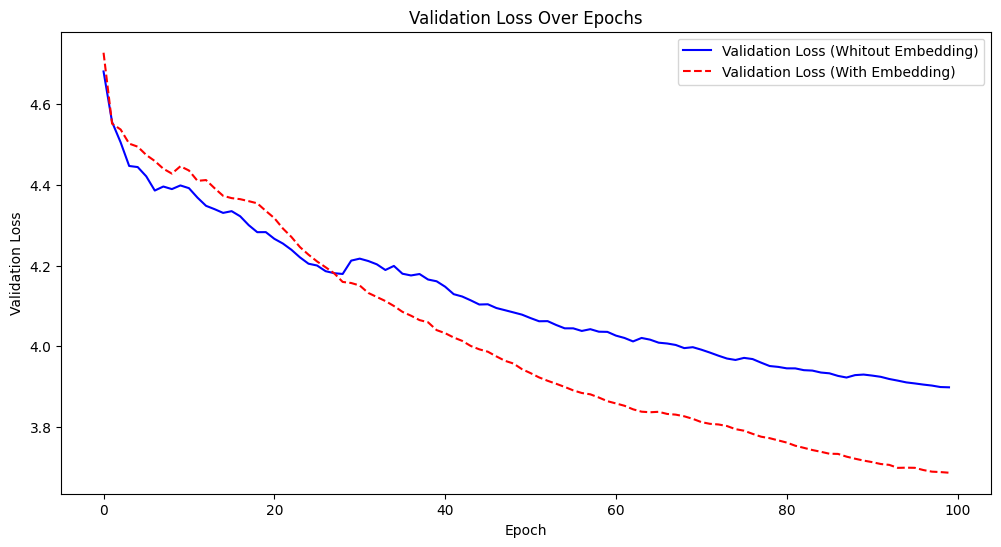

In [ ]:
import matplotlib.pyplot as plt
def plot_val_loss(history1, history2):

    val_loss1 = [epoch['total_loss'] for epoch in history1]
    val_loss2 = [epoch['total_loss'] for epoch in history2]


    plt.figure(figsize=(12, 6))

    # Tracer les pertes de validation
    plt.plot(val_loss1, label="Validation Loss (Whitout Embedding)", linestyle='-', color='b')
    plt.plot(val_loss2, label="Validation Loss (With Embedding)", linestyle='--', color='r')

    plt.xlabel("Epoch")
    plt.ylabel("Validation Loss")
    plt.title("Validation Loss Over Epochs")
    plt.legend()
    plt.show()
plot_val_loss(history1,history2)

## Let's now compare all models (just on the note output)

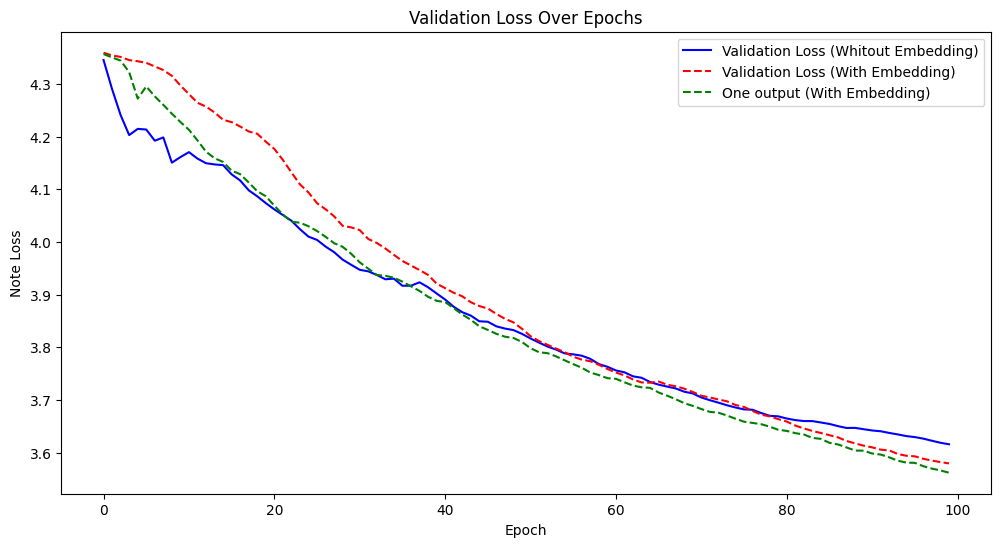

In [ ]:
import matplotlib.pyplot as plt
def plot_val_loss(history1, history2,history3):


    note_loss1 = [epoch['note_loss'] for epoch in history1]
    note_loss2 = [epoch['note_loss'] for epoch in history2]


    plt.figure(figsize=(12, 6))

    # Tracer les pertes de validation
    plt.plot(note_loss1, label="Validation Loss (Without Embedding)", linestyle='-', color='b')
    plt.plot(note_loss2, label="Validation Loss (With Embedding)", linestyle='--', color='r')
    plt.plot(history3, label="One output (With Embedding)", linestyle='--', color='g')

    plt.xlabel("Epoch")
    plt.ylabel("Note Loss")
    plt.title("Validation Loss Over Epochs")
    plt.legend()
    plt.show()
plot_val_loss(history1,history2,history3)

The model with embedding shows slight improvement, utilizing 51 vectors in the embedding layer (50 for notes and 1 for duration). Despite the limited representation of duration with only one vector, we observe a noticeable difference compared to the single-output model. If we had successfully implemented sinusoidal embedding, which would provide a 50-dimensional representation for both notes and durations, the difference in note loss would likely be even more significant.

## Now that we have train our models, Le'ts Generate Music

Number of note to generate

In [ ]:
result_length=200

In [ ]:
def generate_music(model, seed_sequence, num_notes, index_to_pitch):
    """
    Génère une séquence de musique en utilisant le modèle.

    Args:
    - model : modèle entraîné.
    - seed_sequence : séquence initiale (numpy array de shape (seq_length, 2)).
    - num_notes : nombre de notes à générer.
    - pitch_map : dictionnaire {pitch_number: index} pour transformer les prédictions.

    Returns:
    - generated_notes : liste des notes générées (pitch, duration).
    """
    initial_weights = model.get_weights() # On sauvegarde les poids du modèle à chaque début

    generated_notes = []
    current_sequence = np.copy(seed_sequence)

    for i in range(num_notes):
        initial_weights = model.get_weights() # On remet les poids

        # Reshape pour correspondre aux attentes du modèle
        input_seq = np.expand_dims(current_sequence, axis=0)  # (1, seq_length, 2)
        # Prédire la note et la durée
        predictions = model.predict(input_seq)
        predicted_pitch_index = np.random.choice(len(predictions[0][0]), p=predictions[0][0])  # Classification
        #predicted_pitch_index = np.argmax(predictions[0][0])
        predicted_duration = predictions[1][0][0]               # Régression

        # On rajoute le fait que si la durée prédite est de 0 on va la mettre à 0.2
        if(predicted_duration==0.0):
            predicted_duration=0.2

        # Mettre à jour la séquence pour la prochaine itération
        next_input = np.array([[predicted_pitch_index, predicted_duration]])  # (1, 2)
        current_sequence = np.vstack([current_sequence[1:], next_input])  # Glisser

        # Convertir l'index prédictif en vrai pitch
        #predicted_pitch = list(index_to_pitch.keys())[predicted_pitch_index]
        predicted_pitch = index_to_pitch.get(predicted_pitch_index)
        # Ajouter la note générée
        # On divise par 100
        generated_notes.append((predicted_pitch, predicted_duration))#/100))
        print(predicted_pitch_index)
        print(predicted_duration)

    return generated_notes

## Import the used models

In [ ]:
model = load_model("model/best_model_manual.h5")
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100, 2)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 100, 100)  │     41,200 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 100)       │     80,400 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ note_output (Dense) │ (None, 78)        │      7,878 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ duration_output     │ (None, 1)         │        101 │ lstm_1[0][0]      │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 129,581 (506.18 KB)

 Trainable params: 129,579 (506.17 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

## Import the beginning of the code we are gonna create


In [ ]:
midi_file_path = 'Test\elise.mid'   # Remplace par le chemin de ton fichier MIDI
midi_info = util.extract_midi_info(midi_file_path)

inter = df[['Pitch Number', 'Duration']].iloc[:100]

inter["Duration"]=inter["Duration"]
inter["Pitch Number"] = inter["Pitch Number"].map(pitch_to_index)
print(inter.head(100).to_string())

    Pitch Number  Duration
0             57  0.094567
1             55  0.093695
2             57  0.094659
3             55  0.092432
4             57  0.093054
5             55  0.093371
6             57  0.091205
7             55  0.091306
8             57  0.092318
9             55  0.087880
10            57  0.091206
11            55  0.090588
12            57  0.090794
13            55  0.090798
14            57  0.093691
15            55  0.092119
16            57  0.092741
17            55  0.093267
18            57  0.091811
19            55  0.092023
20            57  0.094331
21            55  0.091098
22            57  0.092436
23            55  0.092222
24            57  0.089999
25            55  0.089122
26            57  0.090396
27            55  0.088549
28            57  0.090799
29            55  0.090505
30            57  0.091911
31            55  0.091719
32            57  0.092324
33            55  0.091201
34            57  0.093058
35            55  0.092225
3

In [ ]:

seed_sequence =  inter.values # (100, 2)
generated_notes = generate_music(model, seed_sequence, result_length, index_to_pitch)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step
60
0.2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
44
0.2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
55
0.2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
53
0.2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
55
0.2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
60
0.2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
48
0.2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
53
0.2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
55
0.2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
45
0.2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
66
0.2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
52
0.2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
60
0.2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
60
0.2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
57
0.2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
38
0.2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
40
0.2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
40
0.2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
37
0.2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
38
0.2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
64
0.2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
39
0.2
1/1 ━━━━━

In [ ]:
output_filename="Generated_music/generated_music.mid"
output_wav_path = 'Generated_music/generated_audio.wav'
# Sauvegarder la musique générée
util.save_midi(generated_notes,output_filename)
util.midi_to_wav(output_filename, output_wav_path)

MIDI file saved as Generated_music/generated_music.mid


In [ ]:
from IPython.display import Audio
# Charger et jouer le fichier audio
Audio("Generated_music/generated_audio.wav")

ValueError: rate must be specified when data is a numpy array or list of audio samples.

# Let's try with the embedding model too

In [ ]:
def generate_music_embedding(model, seed_sequence, num_notes, index_to_pitch):
    """
    Génère une séquence de musique en utilisant le modèle.

    Returns:
    - generated_notes : liste des notes générées (pitch, duration).
    """
    initial_weights = model.get_weights() # On sauvegarde les poids du modèle à chaque début

    generated_notes = []
    current_sequence = np.copy(seed_sequence)

    for i in range(num_notes):
        initial_weights = model.get_weights() # On remet les poids

        # Reshape pour correspondre aux attentes du modèle
        input_seq = np.expand_dims(current_sequence, axis=0)  # (1, seq_length, 2)

        input_note = input_seq[:,:,0]
        input_duration = input_seq[:,:,1]

        # Prédire la note et la durée
        predictions = model.predict([input_note,input_duration])
        predicted_pitch_index = np.random.choice(len(predictions[0][0]), p=predictions[0][0])  # Classification
        #predicted_pitch_index = np.argmax(predictions[0][0])
        predicted_duration = predictions[1][0][0]               # Régression

        # On rajoute le fait que si la durée prédite est de 0 on va la mettre à 0.05
        if(predicted_duration==0.0):
            predicted_duration=0.2

        # Mettre à jour la séquence pour la prochaine itération
        next_input = np.array([[predicted_pitch_index, predicted_duration]])  # (1, 2)
        current_sequence = np.vstack([current_sequence[1:], next_input])  # Glisser

        # Convertir l'index prédictif en vrai pitch
        #predicted_pitch = list(index_to_pitch.keys())[predicted_pitch_index]
        predicted_pitch = index_to_pitch.get(predicted_pitch_index)
        # Ajouter la note générée
        # On divise par 100
        generated_notes.append((predicted_pitch, predicted_duration))#/100))
        print(predicted_pitch_index)
        print(predicted_duration)

    return generated_notes

In [ ]:
model_embedding = load_model("model/best_model_embedding.h5")
model_embedding.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ note_input          │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 100, 50)   │      3,900 │ note_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ duration_input      │ (None, 100, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 100, 51)   │          0 │ embedding[0][0],  │
│ (Concatenate)       │                   │            │ duration_input[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 100, 100)  │     60,800 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 100)       │     80,400 │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ note_output (Dense) │ (None, 78)        │      7,878 │ lstm_3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ duration_output     │ (None, 1)         │        101 │ lstm_3[0][0]      │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 153,081 (597.98 KB)

 Trainable params: 153,079 (597.96 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [ ]:

seed_sequence =  inter.values # (100, 2)
generated_notes_embedding = generate_music_embedding(model_embedding, seed_sequence, result_length, index_to_pitch)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step
46
0.2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
45
0.11256628
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
60
0.2433523
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
57
0.045235284
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
54
0.2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
61
0.2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
50
0.2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
53
0.049674146
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
65
0.12764879
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
51
0.0028062984
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
46
0.101848036
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
36
0.24341227
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
44
0.23498288
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
38
0.24447529
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
60
0.26680282
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
41
0.13117881
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
36
0.20878212
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
53
0.20361972
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
39
0.18572597
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5

In [ ]:
output_filename="Generated_music/generated_music_embedding.mid"
output_wav_path = 'Generated_music/generated_audio_embedding.wav'
# Sauvegarder la musique générée
util.save_midi(generated_notes_embedding,output_filename)
util.midi_to_wav(output_filename, output_wav_path)

MIDI file saved as Generated_music/generated_music_embedding.mid


In [ ]:
from IPython.display import Audio
# Charger et jouer le fichier audio
Audio('Generated_music/generated_audio_embedding.wav')

ValueError: rate must be specified when data is a numpy array or list of audio samples.

# Let's try with the model with one output too

In [ ]:
def generate_music_one_output(model, seed_sequence, num_notes, index_to_pitch):
    """
    Génère une séquence de musique en utilisant le modèle.

    Returns:
    - generated_notes : liste des notes générées (pitch, duration).
    """
    initial_weights = model.get_weights() # On sauvegarde les poids du modèle à chaque début

    generated_notes = []
    current_sequence = np.copy(seed_sequence)

    for i in range(num_notes):
        initial_weights = model.get_weights() # On remet les poids

        # Reshape pour correspondre aux attentes du modèle
        input_seq = np.expand_dims(current_sequence, axis=0)  # (1, seq_length, 2)

        input_note = input_seq[:,:,0]

        # Prédire la note et la durée
        predictions = model.predict(input_note)
        predicted_pitch_index = np.random.choice(len(predictions[0]), p=predictions[0])
        #predicted_pitch_index = np.argmax(predictions[0])

        # We will use always 0.2 s for our one output prediction
        predicted_duration = 0.2


        # Mettre à jour la séquence pour la prochaine itération
        next_input = np.array([[predicted_pitch_index, predicted_duration]])  # (1, 2)
        current_sequence = np.vstack([current_sequence[1:], next_input])  # Glisser

        # Convertir l'index prédictif en vrai pitch
        #predicted_pitch = list(index_to_pitch.keys())[predicted_pitch_index]
        predicted_pitch = index_to_pitch.get(predicted_pitch_index)
        # Ajouter la note générée
        generated_notes.append((predicted_pitch, predicted_duration))
        print(predicted_pitch_index)
        print(predicted_duration)

    return generated_notes

In [ ]:
model_one_output = load_model("model/best_model_one_output.h5")
model_one_output.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ note_input (InputLayer)         │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 100, 50)        │         3,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 100, 100)       │        60,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ note_output (Dense)             │ (None, 78)             │         7,878 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 152,580 (596.02 KB)

 Trainable params: 152,578 (596.01 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [ ]:

seed_sequence =  inter.values # (100, 2)
generated_notes_one_output = generate_music_one_output(model_one_output, seed_sequence, result_length, index_to_pitch)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step
51
0.2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
53
0.2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
50
0.2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
46
0.2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
51
0.2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
53
0.2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
49
0.2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
48
0.2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
51
0.2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
51
0.2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
57
0.2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
53
0.2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
40
0.2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
43
0.2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
42
0.2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
35
0.2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
26
0.2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
39
0.2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
43
0.2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
33
0.2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
39
0.2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
35
0.2
1/1 ━━━━

In [ ]:
output_filename="Generated_music/generated_music_one_note.mid"
output_wav_path = 'Generated_music/generated_music_one_note.wav'
# Sauvegarder la musique générée
util.save_midi(generated_notes_one_output,output_filename)
util.midi_to_wav(output_filename, output_wav_path)

MIDI file saved as Generated_music/generated_music_one_note.mid


In [ ]:
from IPython.display import Audio
# Charger et jouer le fichier audio
Audio('Generated_music/generated_music_one_note.wav' )

ValueError: rate must be specified when data is a numpy array or list of audio samples.

# Conclusion

This project successfully demonstrates the power of Long Short-Term Memory (LSTM) networks in the domain of music generation. By leveraging sequences of MIDI note pitches and durations, we explored three distinct architectures:

1. **Raw Note Model**
2. **Model with Embedding**
3. **Note-Only Embedding Model**

Each model was trained using custom batch generators and optimized with a dual-output loss (note classification and duration regression), with robust training routines that included manual early stopping and model checkpointing. The generation process included probabilistic sampling to encourage musical diversity and post-processing steps to convert generated sequences into audible `.wav` files.  
.  

Our comparisons revealed the advantages of embedding representations in capturing musical context, and the models demonstrated the ability to produce coherent and rhythmically structured musical sequences from a short seed input. These results highlight the potential of deep learning techniques not only for creative applications but also for interactive, generative tools in music technology.  
.  

Here are a few points that summarizes our comparison made on the note loss graph over 100 epochs:
  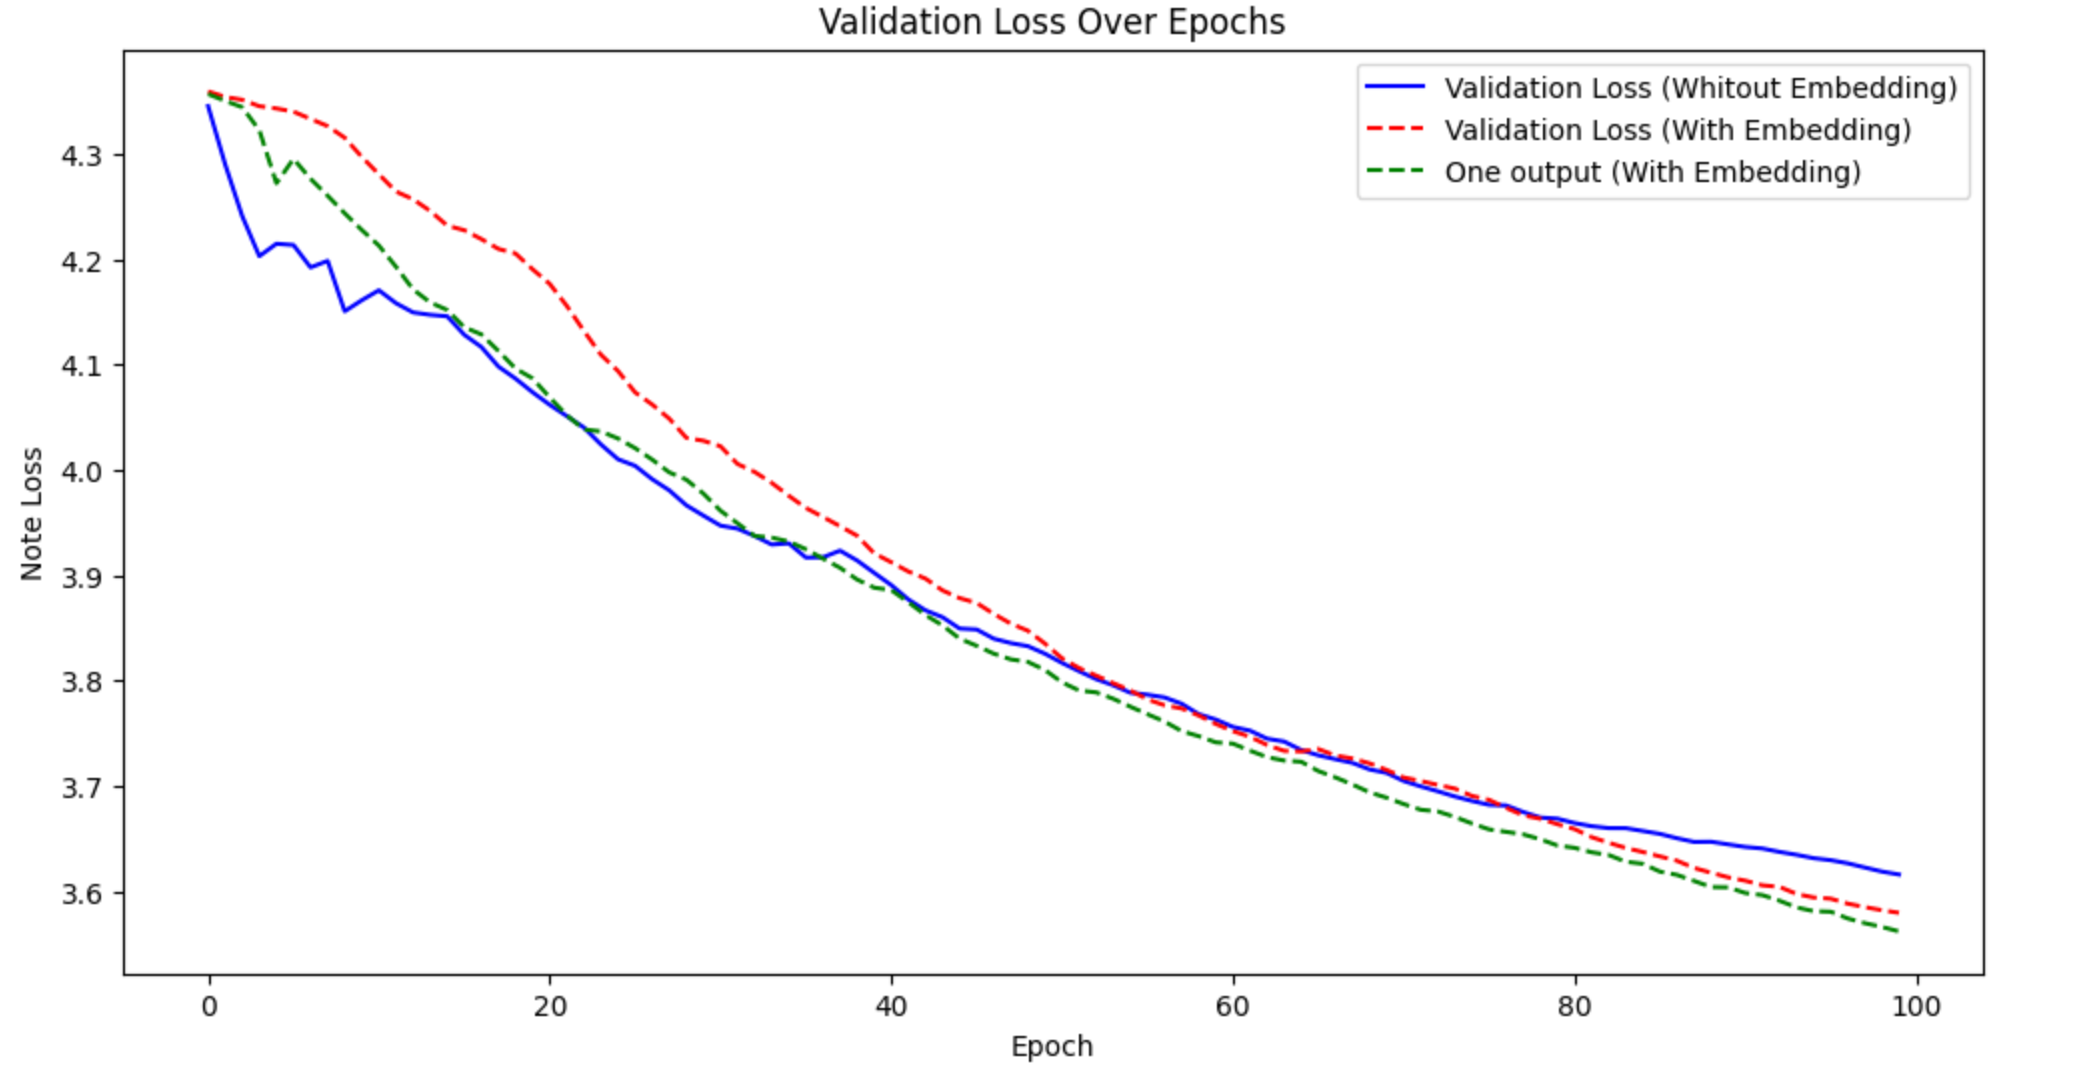

**I.** Embedding-based models outperformed raw input models in the long term, demonstrating the advantage of learned pitch representations for musical understanding.

**II.** The embedding-only model (green line) achieved the lowest validation loss, showing that simplifying the output space (predicting only pitch) leads to better pitch modeling and more stable training.

**III.** The dual-output embedding model (red line) improved steadily but was slightly constrained by the added task of predicting duration.

**IV.** The raw input model (blue line) showed faster early learning but plateaued earlier, suggesting a limited capacity to generalize musical structure without embeddings.

Looking forward, this system provides a strong foundation for more advanced musical modeling, including genre adaptation, multi-instrument composition, or real-time human-in-the-loop improvisation systems. The modular architecture also opens doors to extensions with Transformer models and attention mechanisms.